In [1]:
import pandas as pd
import boto3
import sagemaker

# session and bucket initilization
sees = sagemaker.Session()
bucket = 'raj-raw-sales-data'
file_key = 'customers_sales.csv' 

# Creating S3 path
data_location = f's3://{bucket}/{file_key}'

# reading dataset using pandas and displaying first few rows.
df = pd.read_csv(data_location)
df.head()

Unable to load JumpStart region config.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/constants.py", line 69, in _load_region_config
    with open(filepath) as f:
         ^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/sagemaker/jumpstart/region_config.json'


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


/home/ec2-user/anaconda3/envs/python3/lib/python3.12/site-packages/fsspec/registry.py:301: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


In [2]:
# Checking for missing values in each column
print(f"Missing values per column: \n {df.isnull().sum()}")


# Checking for negative sales
negative_sales = df[df['Quantity'] < 0]
print(f"\nNumber of rows with negative sales: {len(negative_sales)}")

Missing values per column: 
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Number of rows with negative sales: 10624


In [3]:
# Dropping Description and CustomerID Columns
df = df.drop(columns=['CustomerID'])
df = df.drop(columns=['Description'])

In [4]:
#Keeping only the rows which are strictly greater then zero and printing how many rows we have left.
df = df[df['Quantity'] > 0]

print(f'Number of rows left: {len(df)}')

Number of rows left: 531285


In [5]:
# Creating new column for total money on each line
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# Dropping the time in the Invoice date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# Group all the rows by the exact date, and sum up the Revenue
daily_sales = df.groupby('InvoiceDate')['Revenue'].sum().reset_index()

daily_sales.head()

/tmp/ipykernel_19688/237907593.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date


,InvoiceDate,Revenue
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-05,31774.95
4,2010-12-06,54830.46


In [6]:
# Ensure the Date column is a true Datetime object
daily_sales['InvoiceDate'] = pd.to_datetime(daily_sales['InvoiceDate'])

# Set the Date as the "Index"
daily_sales = daily_sales.set_index('InvoiceDate')

# Create a complete calendar from our first day to our last day
complete_calendar = pd.date_range(start=daily_sales.index.min(), end=daily_sales.index.max())

# Snap our data to this complete calendar, filling blanks with 0
daily_sales = daily_sales.reindex(complete_calendar, fill_value=0)

# Bringig the Date back as a normal column
daily_sales = daily_sales.reset_index().rename(columns={'index': 'InvoiceDate'})

daily_sales.head(5)

,InvoiceDate,Revenue
0,2010-12-01,58960.79
1,2010-12-02,47748.38
2,2010-12-03,46943.71
3,2010-12-04,0.00
4,2010-12-05,31774.95


In [7]:
# Saving daily_sales 
daily_sales.to_csv('clean_daily_sales.csv', index=False)

# Uploading clean_daily_sales.csv file into S3
clean_data_uri = sees.upload_data(path='clean_daily_sales.csv', bucket=bucket, key_prefix='ready-for-ai')

print(f'Sucessfully uploaded cleaned data to: {clean_data_uri}') 

Sucessfully uploaded cleaned data to: s3://raj-raw-sales-data/ready-for-ai/clean_daily_sales.csv


In [8]:
# Checking the timeline of clean dataset
start_date = daily_sales['InvoiceDate'].min()
end_date = daily_sales['InvoiceDate'].max()

print(f"Our data starts on: {start_date}")
print(f"Our data ends on: {end_date}")

Our data starts on: 2010-12-01 00:00:00
Our data ends on: 2011-12-09 00:00:00


In [9]:
# Breaking date into numeric columns for XG Boost
daily_sales['Month'] = daily_sales['InvoiceDate'].dt.month
daily_sales['Day'] = daily_sales['InvoiceDate'].dt.day
daily_sales['DayOfWeek'] = daily_sales['InvoiceDate'].dt.dayofweek
daily_sales['Year'] = daily_sales['InvoiceDate'].dt.year

# making date as index
model_data = daily_sales.set_index('InvoiceDate')

#Spliting the data
split_date = '2011-11-01'

#slicing the dataset
train_data = model_data.loc[model_data.index < split_date]
test_data = model_data.loc[model_data.index >= split_date]

print(f'Training days: {len(train_data)}')
print(f'Testing Days: {len(test_data)}')

Training days: 335
Testing Days: 39


In [10]:
# Rearrange columns
columns_order = ['Revenue', 'Month', 'Day', 'DayOfWeek', 'Year']
train_data = train_data[columns_order]
test_data = test_data[columns_order]

# Saving pure CSVs
train_data.to_csv('train.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

# Uploading  files to a specific XGBoost folder in S3 bucket
prefix = 'xgboost-sales-model'

train_uri = sees.upload_data(path='train.csv', bucket=bucket, key_prefix=f'{prefix}/train')
test_uri = sees.upload_data(path='test.csv', bucket=bucket, key_prefix=f'{prefix}/test')

print(f"Train data is ready at: {train_uri}")
print(f"Test data is ready at: {test_uri}")

Train data is ready at: s3://raj-raw-sales-data/xgboost-sales-model/train/train.csv
Test data is ready at: s3://raj-raw-sales-data/xgboost-sales-model/test/test.csv


In [11]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

# Getting the AWS region
region = boto3.Session().region_name

# Grabbing the Amazon's official, pre-built XGBoost algorithm
xgboost_container = image_uris.retrieve('xgboost', region, '1.7-1')

#creating model
xgb_model = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output', 
    sagemaker_session=sees
)

# Setting the Hyperparameters 
xgb_model.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    objective='reg:squarederror', 
    num_round=100
)

# storing data into S3
s3_input_train = TrainingInput(s3_data=train_uri, content_type='csv')
s3_input_validation = TrainingInput(s3_data=test_uri, content_type='csv')

# training the model
xgb_model.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2026-02-27-20-38-10-165


2026-02-27 20:38:11 Starting - Starting the training job...
2026-02-27 20:38:27 Starting - Preparing the instances for training...
2026-02-27 20:38:52 Downloading - Downloading input data...
2026-02-27 20:39:37 Downloading - Downloading the training image......../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-27 20:40:51.475 ip-10-0-124-6.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-27 20:40:51.578 ip-10-0-124-6.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-27:20:40:52:INFO] Imported framework sagemaker_xgboost_container.training
[2026-02-27:20:40:52:INFO] Failed to parse hyperparameter objective value reg:squareder

In [12]:
from sagemaker.serializers import CSVSerializer

# Building the Endpoint
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    serializer=CSVSerializer() 
)

print(f"Success! The AI is awake and listening at: {xgb_predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-27-20-41-27-458
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2026-02-27-20-41-27-458
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2026-02-27-20-41-27-458


--------!Success! The AI is awake and listening at: sagemaker-xgboost-2026-02-27-20-41-27-458


In [13]:
import numpy as np

# Dropping the Revenue column from the test data
test_features = test_data.drop(columns=['Revenue'])

# predictions

predictions_raw = xgb_predictor.predict(test_features.values)
predictions_text = predictions_raw.decode('utf-8').strip()
predictions = [float(val) for val in predictions_text.split('\n')]

# Actual Revenue and Predicted Revenue
results = test_data[['Revenue']].copy()
results.rename(columns={'Revenue': 'Actual_Revenue'}, inplace=True)
results['Predicted_Revenue'] = predictions

results.head(10)

,Actual_Revenue,Predicted_Revenue
InvoiceDate,,
2011-11-01,29155.15,62434.324219
2011-11-02,45888.34,52328.792969
2011-11-03,63561.49,58441.519531
2011-11-04,62977.36,49151.910156
2011-11-05,0.00,8687.205078
2011-11-06,42946.34,28112.773438
2011-11-07,85881.81,79551.148438
2011-11-08,57700.24,78207.828125
2011-11-09,66127.57,45160.738281


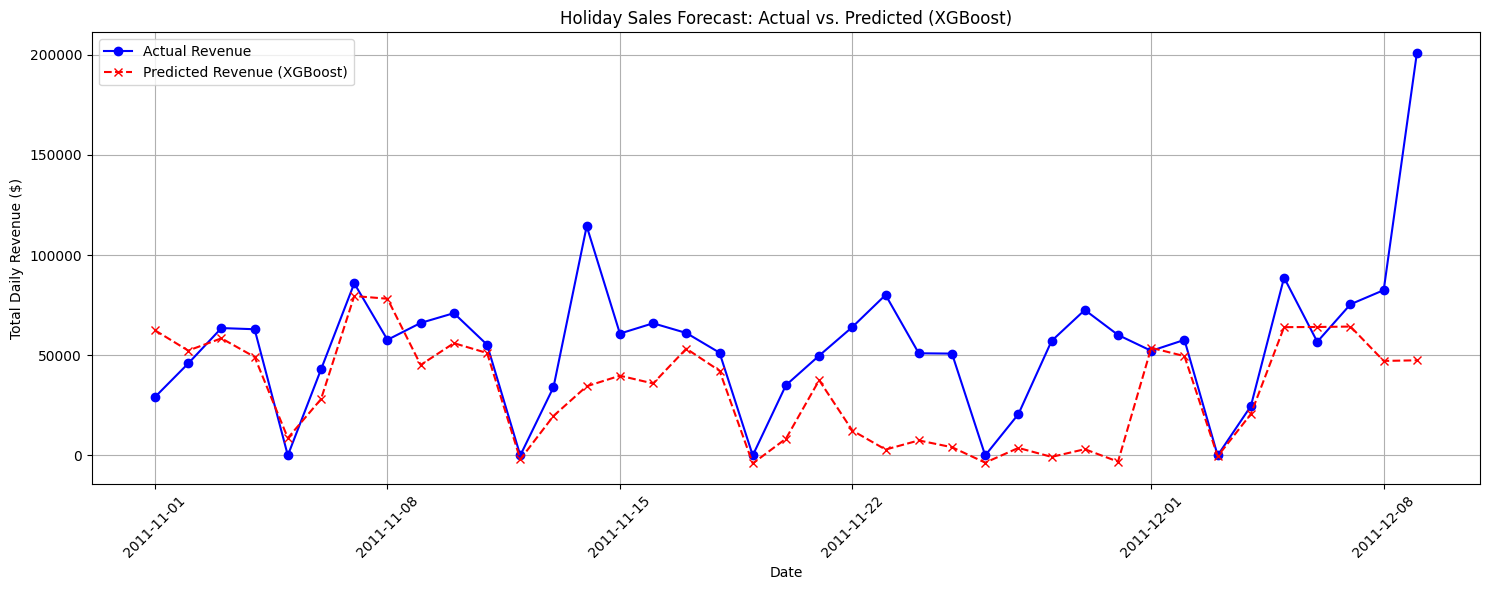

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(results.index, results['Actual_Revenue'], label='Actual Revenue', marker='o', color='blue')
plt.plot(results.index, results['Predicted_Revenue'], label='Predicted Revenue (XGBoost)', marker='x', color='red', linestyle='--')
plt.title('Holiday Sales Forecast: Actual vs. Predicted (XGBoost)')
plt.xlabel('Date')
plt.ylabel('Total Daily Revenue ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(results['Actual_Revenue'], results['Predicted_Revenue'])

# 2. Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(results['Actual_Revenue'], results['Predicted_Revenue']))

print(f"Mean Absolute Error (MAE): ${mae:,.2f} per day")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f} per day")

Mean Absolute Error (MAE): $26,471.98 per day
Root Mean Squared Error (RMSE): $40,068.31 per day


In [16]:
# Deleting the endpoint
xgb_predictor.delete_endpoint()

print("Endpoint successfully deleted!")

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2026-02-27-20-41-27-458
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2026-02-27-20-41-27-458


Endpoint successfully deleted!
